# Machine Learning Optimization for Credit Analysis

## In this notebook we will Test different Models on the dataset

- first we test different models then we optimize the most promising one

_refear to the other notebook in the repository for the previous phase_


In [1]:
# Libraries for Data Handling
import pandas as pd #To work with dataset
import numpy as np #Math library
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn

In [2]:
# Libraries for ML pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score, precision_score, recall_score, f1_score #To evaluate our model

from sklearn.model_selection import GridSearchCV

# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.metrics import roc_curve

In [3]:

#Importing the data
df = pd.read_csv("german_credit_data.csv",index_col=0)

In [4]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


### Handling Categorical Features

In [6]:
# Exploring the values for each feture
print("Purpose : ",df.Purpose.unique())
print("Sex : ",df.Sex.unique())
print("Housing : ",df.Housing.unique())
print("Saving accounts : ",df['Saving accounts'].unique())
print("Risk : ",df['Risk'].unique())
print("Checking account : ",df['Checking account'].unique())

Purpose :  ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']
Sex :  ['male' 'female']
Housing :  ['own' 'free' 'rent']
Saving accounts :  [nan 'little' 'quite rich' 'rich' 'moderate']
Risk :  ['good' 'bad']
Checking account :  ['little' 'moderate' nan 'rich']


In [7]:
# Creating Bins for Age groups
interval = (18, 25, 35, 60, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']
df["Age_cat"] = pd.cut(df.Age, interval, labels=cats)

In [8]:
#Function for Creating Dummies Variables
def one_hot_encoder(df, nan_as_category = False):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category, drop_first=True)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [9]:
#Purpose to Dummies Variable
df = df.merge(pd.get_dummies(df.Purpose, drop_first=True, prefix='Purpose'), left_index=True, right_index=True)
#Sex feature in dummies
df = df.merge(pd.get_dummies(df.Sex, drop_first=True, prefix='Sex'), left_index=True, right_index=True)
# Housing get dummies
df = df.merge(pd.get_dummies(df.Housing, drop_first=True, prefix='Housing'), left_index=True, right_index=True)
# Housing get Saving Accounts
df = df.merge(pd.get_dummies(df["Saving accounts"], drop_first=True, prefix='Savings'), left_index=True, right_index=True)
# Housing get Risk
df = df.merge(pd.get_dummies(df.Risk, prefix='Risk'), left_index=True, right_index=True)
# Housing get Checking Account
df = df.merge(pd.get_dummies(df["Checking account"], drop_first=True, prefix='Check'), left_index=True, right_index=True)
# Housing get Age categorical
df = df.merge(pd.get_dummies(df["Age_cat"], drop_first=True, prefix='Age_cat'), left_index=True, right_index=True)

In [10]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,...,Savings_moderate,Savings_quite rich,Savings_rich,Risk_bad,Risk_good,Check_moderate,Check_rich,Age_cat_Young,Age_cat_Adult,Age_cat_Senior
0,67,male,2,own,NaN,little,1169,6,radio/TV,good,...,0,0,0,0,1,0,0,0,0,1
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad,...,0,0,0,1,0,1,0,0,0,0
2,49,male,1,own,little,NaN,2096,12,education,good,...,0,0,0,0,1,0,0,0,1,0
3,45,male,2,free,little,little,7882,42,furniture/equipment,good,...,0,0,0,0,1,0,0,0,1,0
4,53,male,2,free,little,little,4870,24,car,bad,...,0,0,0,1,0,0,0,0,1,0


In [11]:
#Excluding the missing columns
del df["Saving accounts"]
del df["Checking account"]
del df["Purpose"]
del df["Sex"]
del df["Housing"]
del df["Age_cat"]
del df["Risk"]
del df['Risk_good']

### Reducing the Scale of Credit amount

In [12]:
df['Credit amount'] = np.log(df['Credit amount'])

### Preparing Dataset for ML pipeline

In [13]:
#Creating the X and y variables
X = df.drop('Risk_bad', 1).values
y = df["Risk_bad"].values

C:\Users\mdibene\AppData\Local\Temp\ipykernel_1192\315002513.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df.drop('Risk_bad', 1).values


In [14]:
# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

### ML pipeline for Evaluating different ML algorithms

In [15]:
%%capture
seed = 7


models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('XGB', XGBClassifier()))

# Model evaluation
results = []
names = []
scoring = 'recall'

for name, model in models:
        kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)

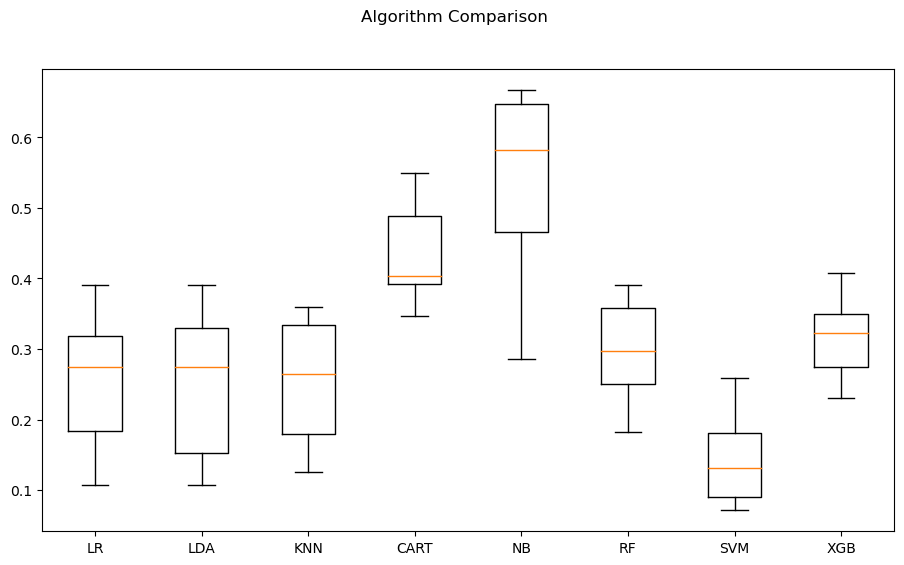

In [16]:
# boxplot comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [17]:
GNB = GaussianNB()

# Fitting with train data
model = GNB.fit(X_train, y_train)

In [18]:
print("Training score data: ")
print(model.score(X_train, y_train))

Training score data: 
0.672


In [19]:
y_pred = model.predict(X_test)

print(accuracy_score(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

0.608


[[119  59]
 [ 39  33]]


              precision    recall  f1-score   support

           0       0.75      0.67      0.71       178
           1       0.36      0.46      0.40        72

    accuracy                           0.61       250
   macro avg       0.56      0.56      0.56       250
weighted avg       0.64      0.61      0.62       250



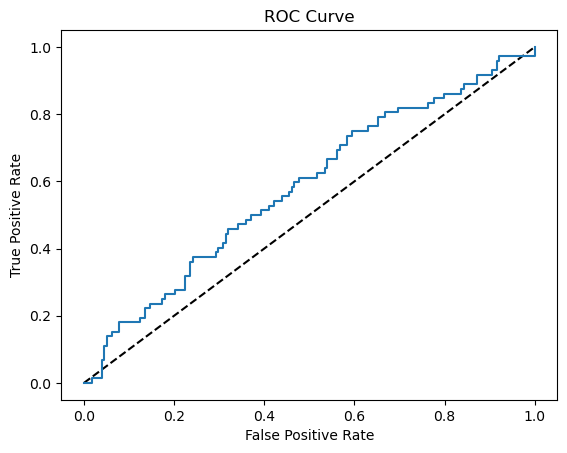

In [20]:
y_pred_prob = model.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### Summary:

- In General the performance of the different models mesured using the Recall is relly poor

- The best performing model is the Naive Bayes Classifier followed by the Decision tree Classifier and The XGBoost Algorithm

## Optimization Section

### Grid Search For Random Forest

In [21]:
param_grid = {"max_depth": [3,5, 7, 10,None],
              "n_estimators":[3,5,10,25,50,150],
              "max_features": [4,7,15,20]}

#Creating the classifier
model_rf = RandomForestClassifier(random_state=2)

In [22]:
%%capture
grid_search = GridSearchCV(model_rf, param_grid=param_grid, cv=5, scoring='recall', verbose=4)
grid_search.fit(X_train, y_train)

In [23]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.4028985507246377
{'max_depth': None, 'max_features': 20, 'n_estimators': 3}


In [24]:
rf = RandomForestClassifier(max_depth=None, max_features=20, n_estimators=3, random_state=2)

#trainning with the best params
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=20, n_estimators=3, random_state=2)

In [25]:
#Testing the model 
#Predicting using our  model
y_pred = rf.predict(X_test)

# Verificaar os resultados obtidos
print(accuracy_score(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(fbeta_score(y_test, y_pred, beta=2))

0.636


[[137  41]
 [ 50  22]]


0.3133903133903134


### Grid Search For XGBoost

In [26]:
#Seting the Hyper Parameters
param_test1 = {
 'max_depth':[3,5,6,10],
 'min_child_weight':[3,5,10],
 'gamma':[0.0, 0.1, 0.2, 0.3, 0.4],
# 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10],
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}

model_xg = XGBClassifier(random_state=2)

In [27]:
%%capture
grid_search = GridSearchCV(model_xg, param_grid=param_test1, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

In [28]:
grid_search.best_score_
grid_search.best_params_

{'colsample_bytree': 0.85,
 'gamma': 0.0,
 'max_depth': 5,
 'min_child_weight': 3,
 'subsample': 0.75}

In [29]:
y_pred_xgb = grid_search.predict(X_test)

# Verificaar os resultados obtidos
print(accuracy_score(y_test,y_pred_xgb))
print("\n")
print(confusion_matrix(y_test, y_pred_xgb))
print("\n")
print(recall_score(y_test, y_pred_xgb))
print("\n")
print(precision_score(y_test, y_pred_xgb))

0.692


[[149  29]
 [ 48  24]]


0.3333333333333333


0.4528301886792453


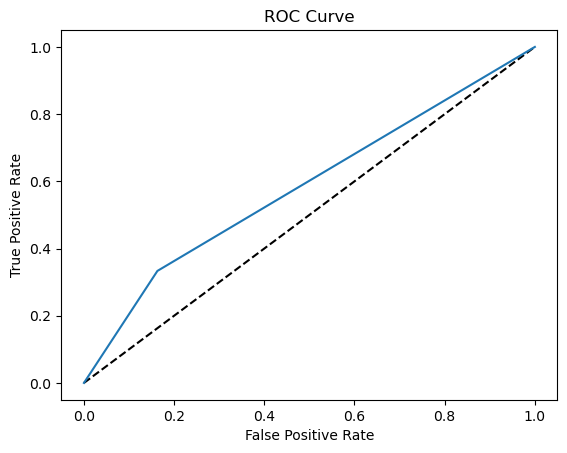

In [30]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_xgb)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### Summary:

- Overall the results are poor and the models are not able to correctly predict the false positive (most dangerous from a bank prospective)

- Using the Grid search the models slightly improved the performance

- The accuracy score for XGB and RF indicate that they both outperforme the NB classifier. 



### Bayesian Optimization for random forest

### Bayesian optimization for Hyperparameter tuning

Bayesian optimization (BO) is an automated procedure for hyperparameter tuning. BO uses gaussian process to model mean and variance of the target function.

Gaussian process
Guassian process is a prior distribution on functions, and in the case of hyperparameter tuning it will be of the form:

$f:χ→R$
 

Where  $χ$
  is the space of hyperparameter set we are tuning, and  $f$
  is the target function decided based on the criteria on which the hyperparameters needs to be tuned. For a gaussian process,  $p(f|χ)$
  follows a normal distribution. In our problem, we define mean accuracy from five fold cross validation as the target function.

Acquisition function
It is assumed that the function  $f(x)$
  is drawn from a gaussain process prior and our observation is of the form  $xi,yi$
 , where

$yi∼N(f(xi),ν)$
  ,  ν
  is the variance of noise introduced into the function observations.

This prior and the data induce a posterior over functions,the acquisition function, $a:χ→R+$
 , determines what points in  $χ$
  to be evaluated next.

There are different choices for acquisition functions, mainly

1) Upper Confidence Bounds method
2) Expected improvement method
3) Probability Of Improvement method

Acquisiton function follows a greedy approach to find the optimum hyperparameters in each step, and with a fixed step of iteration, we are expected to get the suitable hyperparameters for our model.

In [31]:
#importing BO
from bayes_opt import BayesianOptimization

In [32]:
# All the tunable parameters for the Random forest
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 20,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 3,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2,
 'verbose': 0,
 'warm_start': False}

In [33]:
# Defining Function for keeping track of the progress during the training

In [34]:
def stratified_kfold_score(clf,X,y,n_fold):
    X,y = X,y
    strat_kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)
    accuracy_list = []

    for train_index, test_index in strat_kfold.split(X, y):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        accuracy_test = accuracy_score(preds,y_test_fold)
        accuracy_list.append(accuracy_test)

    return np.array(accuracy_list).mean()

In [35]:
# Function with model parameters For B.O.
def bo_params_rf(max_samples,n_estimators,max_features):
    
    params = {
        'max_samples': max_samples,
        'max_features':max_features,
        'n_estimators':int(n_estimators)
    }
    clf = RandomForestClassifier(max_samples=params['max_samples'],max_features=params['max_features'],n_estimators=params['n_estimators'])
    score = stratified_kfold_score(clf,X_train, y_train,5)
    return score

In [36]:
rf_bo = BayesianOptimization(bo_params_rf, {
                                              'max_samples':(0.5,1),
                                                'max_features':(0.5,1),
                                              'n_estimators':(3,150)
                                             })

In [37]:
results = rf_bo.maximize(n_iter=200, init_points=20,acq='ei')

|   iter    |  target   | max_fe... | max_sa... | n_esti... |
-------------------------------------------------------------


C:\Users\mdibene\AppData\Local\Temp\ipykernel_1192\785250422.py:1: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  results = rf_bo.maximize(n_iter=200, init_points=20,acq='ei')


| 1         | 0.7       | 0.8155    | 0.9105    | 98.78     |
| 2         | 0.696     | 0.5465    | 0.9508    | 66.77     |
| 3         | 0.6867    | 0.7949    | 0.8079    | 125.9     |
| 4         | 0.6813    | 0.9495    | 0.5356    | 27.97     |
| 5         | 0.6947    | 0.5078    | 0.9413    | 139.0     |
| 6         | 0.692     | 0.8533    | 0.7597    | 10.54     |
| 7         | 0.7013    | 0.501     | 0.9884    | 62.2      |
| 8         | 0.6827    | 0.8946    | 0.812     | 119.9     |
| 9         | 0.688     | 0.6142    | 0.8373    | 8.414     |
| 10        | 0.696     | 0.5863    | 0.5236    | 100.7     |
| 11        | 0.6707    | 0.836     | 0.7945    | 4.21      |
| 12        | 0.684     | 0.571     | 0.9585    | 149.4     |
| 13        | 0.7       | 0.958     | 0.5602    | 27.83     |
| 14        | 0.6987    | 0.9935    | 0.6228    | 22.8      |
| 15        | 0.696     | 0.948     | 0.6993    | 137.7     |
| 16        | 0.6853    | 0.9778    | 0.9582    | 105.8     |
| 17    

| 82        | 0.6733    | 0.5096    | 0.7912    | 49.77     |
| 83        | 0.6973    | 0.835     | 0.8286    | 98.75     |
| 84        | 0.684     | 0.7891    | 0.5509    | 100.4     |
| 85        | 0.6893    | 0.9137    | 0.5915    | 48.26     |
| 86        | 0.6987    | 0.703     | 0.7572    | 78.08     |
| 87        | 0.68      | 0.9804    | 0.9642    | 102.2     |
| 88        | 0.672     | 0.5514    | 0.9091    | 7.657     |
| 89        | 0.6947    | 0.5519    | 0.9011    | 73.53     |
| 90        | 0.684     | 0.6975    | 0.8843    | 139.9     |
| 91        | 0.7067    | 0.7621    | 0.6315    | 54.88     |
| 92        | 0.6907    | 0.8482    | 0.5758    | 140.5     |
| 93        | 0.704     | 0.5561    | 0.991     | 13.4      |
| 94        | 0.692     | 0.9099    | 0.6465    | 112.0     |
| 95        | 0.704     | 0.5157    | 0.8384    | 6.089     |
| 96        | 0.692     | 0.7153    | 0.8215    | 42.5      |
| 97        | 0.6893    | 0.9786    | 0.8183    | 46.53     |
| 98    

| 163       | 0.696     | 0.6342    | 0.6488    | 148.0     |
| 164       | 0.692     | 0.7378    | 0.5752    | 27.46     |
| 165       | 0.6867    | 0.6235    | 0.5736    | 127.5     |
| 166       | 0.6947    | 0.6848    | 0.5591    | 52.99     |
| 167       | 0.6813    | 0.5696    | 0.9979    | 9.632     |
| 168       | 0.68      | 0.6103    | 0.8396    | 45.42     |
| 169       | 0.688     | 0.9754    | 0.5094    | 19.32     |
| 170       | 0.696     | 0.6346    | 0.6005    | 36.15     |
| 171       | 0.6813    | 0.7504    | 0.6849    | 63.57     |
| 172       | 0.684     | 0.9496    | 0.6212    | 100.1     |
| 173       | 0.6827    | 0.7679    | 0.7411    | 135.4     |
| 174       | 0.6907    | 0.8896    | 0.5829    | 149.8     |
| 175       | 0.6827    | 0.9714    | 0.8318    | 37.74     |
| 176       | 0.6813    | 0.7428    | 0.846     | 52.25     |
| 177       | 0.6947    | 0.8873    | 0.8075    | 31.86     |
| 178       | 0.696     | 0.7823    | 0.7809    | 30.97     |
| 179   

In [38]:
params = rf_bo.max['params']
params['n_estimators']= int(params['n_estimators'])
print(params)

{'max_features': 0.7076868331844419, 'max_samples': 0.51706661601717, 'n_estimators': 100}


In [39]:
rf_vf = RandomForestClassifier(max_samples=params['max_samples'],max_features=params['max_features'],n_estimators=params['n_estimators'])

In [40]:
rf_vf.fit(X_train,y_train)

RandomForestClassifier(max_features=0.7076868331844419,
                       max_samples=0.51706661601717)

In [41]:
bo_pred = rf_vf.predict(X_test)

In [42]:
print(classification_report(bo_pred,y_test))

              precision    recall  f1-score   support

           0       0.90      0.74      0.81       215
           1       0.24      0.49      0.32        35

    accuracy                           0.71       250
   macro avg       0.57      0.61      0.57       250
weighted avg       0.81      0.71      0.74       250



In [43]:
print("Accuracy:{}".format(accuracy_score(bo_pred,y_test)))
print("Precision:{}".format(precision_score(bo_pred,y_test)))
print("Recall:{}".format(recall_score(bo_pred,y_test)))
print("F1 Score:{}".format((f1_score(bo_pred,y_test))))

Accuracy:0.708
Precision:0.2361111111111111
Recall:0.4857142857142857
F1 Score:0.3177570093457944


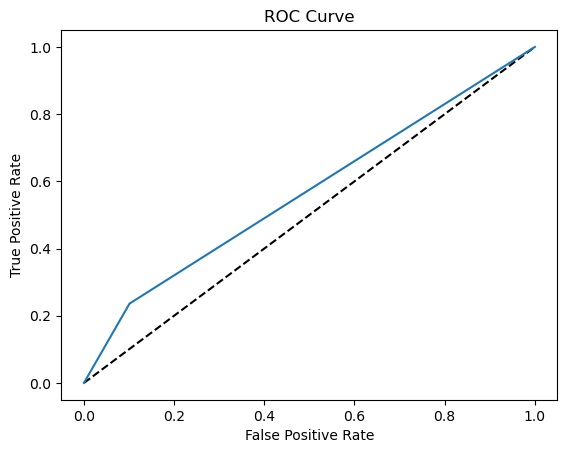

In [44]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, bo_pred)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()